# Navigation in Habitat

> **Note**: This tutorial is borrowed from [ECCV 2020 Tutorials on Habitat](https://aihabitat.org/tutorial/2020/). The official notebook similar to this one can be found [here](https://colab.research.google.com/github/facebookresearch/habitat-sim/blob/main/examples/tutorials/colabs/ECCV_2020_Navigation.ipynb)

This is a self contained notebook, with setup instructions and basic things about the Facebook Habitat simulator. 
The aim is to cover installation and basics of navigation in Habitat simulator.

It is assumed that a headless server is being used.


## Installation and setup

Installing and setting up Habitat (headless with bullet physics)


### Conda

Follow instructions on *GitHub* [here](https://github.com/facebookresearch/habitat-sim#installation). We use `conda`. Run the following


```bash
    # We require python>=3.7 and cmake>=3.10
    conda create -n habitat python=3.7 cmake=3.14.0
    conda activate habitat
    # If installing for headless server
    conda install habitat-sim withbullet headless -c conda-forge -c aihabitat
    # If installing for system with display attached
    conda install habitat-sim withbullet -c conda-forge -c aihabitat
```

You could also use the one-shot setup script (risky!) they have on [GitHub](https://github.com/facebookresearch/habitat-sim/blob/main/examples/colab_utils/colab_install.sh)

The C++ [tests](https://github.com/facebookresearch/habitat-sim#testing) (using `habitat-viewer`) can be run separately. I recommend running them on a server with display attached.


## Before Starting

Some terminology

- An **embodied agent** is an intelligent agent that can perceive and interact with the environment to accomplish any task
- Usually, a **sensor** perceives the **scene**. A **SceneGraph** stores all the scene objects into regions and objects. A **simulator** runs in the back-end, it can update the state of the world (agent + scene graph) and provide observations for sensors.


Before getting started, set up the datasets

```bash
    # Download all the data somewhere
    mkdir -p /scratch/$USER/habitat-data
    cd /scratch/$USER/habitat-data
    python -m habitat_sim.utils.datasets_download --uids ci_test_assets --replace --data-path /scratch/$USER/habitat-data
```

In [1]:
# Place where the dataset was downloaded
data_path = "/scratch/avneesh.mishra/habitat-data"

# Place where all outputs should be stored
out_dir = "/scratch/avneesh.mishra/habitat-out/navigation-tutorial"

## Let's Get Started

In [2]:
# Import everything
import habitat_sim
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os

Some checks 

In [3]:
# Output folder
if os.path.isdir(out_dir):
    print(f"Output directory {out_dir} already exists, overwriting files!")
else:
    os.makedirs(out_dir)
    print(f"Output directory {out_dir} created")
# Data path(s)
assert os.path.isdir(data_path), f"Data not found in {data_path}"

Output directory /scratch/avneesh.mishra/habitat-out/navigation-tutorial created


Utility function for showing color images, semantic masks, depth maps as a row

In [4]:
# Show the data sample
def show_data_sample(img_obj, semantic_obj=None, depth_obj=None):
    """
        Visualize the data passed (only one sample). `None` items are ignored.
        - img_obj: (H, W, 4): RGBA image
        - semantic_obj: (H, W): Semantic segmentation map (instance or class)
        - depth_obj: (H, W): Depth map of corresponding pixels
    """
    # RGB Image
    rgb_img = Image.fromarray(img_obj, mode="RGBA")
    data = [rgb_img]
    titles = ["RGB"]
    # Semantic object
    from habitat_sim.utils.common import d3_40_colors_rgb
    if semantic_obj is not None:
        sem_img = Image.new(mode="P", # Color palette image
            size=(semantic_obj.shape[1], semantic_obj.shape[0]))
        sem_img.putpalette(d3_40_colors_rgb.flatten())
        sem_img.putdata((semantic_obj.flatten() % 40).astype(np.uint8))
        sem_img = sem_img.convert(mode="RGBA")
        data.append(sem_img)
        titles.append("Semantic")
    # Depth object
    if depth_obj is not None:
        depth_img = Image.fromarray((depth_obj / 10 * 255).astype(np.uint8),
            mode="L")   # Greyscale image
        data.append(depth_img)
        titles.append("Depth")
    # Show the image(s)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, len(titles))
    for i, img in enumerate(data):
        ax = fig.add_subplot(gs[0, i])
        ax.set_axis_off()
        ax.set_title(titles[i])
        ax.imshow(img)
    plt.show(block=False)

### Visualize a scene

Read the scene

3D models are stored in the [GLB file format](https://visao.ca/what-is-glb-file/)

In [5]:
test_scene = "/scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.glb"

assert os.path.isfile(test_scene)

Simulator settings (backend and agent)

- [habitat_sim.simulator.Configuration](https://aihabitat.org/docs/habitat-sim/habitat_sim.simulator.Configuration.html): Takes the configurations of the simulation environment and various agents.
    - [habitat_sim.sim.SimulatorConfiguration](https://aihabitat.org/docs/habitat-sim/habitat_sim.sim.SimulatorConfiguration.html): Simulator configuration (scene and environment)
    - [habitat_sim.agent.AgentConfiguration](https://aihabitat.org/docs/habitat-sim/habitat_sim.agent.AgentConfiguration.html): Agent configuration . We'll only attach sensors, but you can also define agent as cylinder and define action spaces.
        - [habitat_sim.sensor.SensorSpec](https://aihabitat.org/docs/habitat-sim/habitat_sim.sensor.SensorSpec.html): Sensor specifications

In [7]:
sim_settings = {
    "backend": {
        "scene": test_scene,
    },
    "agent": {
        "number": 0,
        "sensor_height": 1.5,
        # Spatial resolution of observations
        "sr_width": 256,
        "sr_height": 256
    }
}

In [8]:
# Make simple configurations
def make_habitat_cfg(settings):
    sim_cfg = habitat_sim.sim.SimulatorConfiguration()
    # Backend configurations
    sim_cfg.scene_id = settings["backend"]["scene"]
    # Agent(s) configurations
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    # Sensor(s) for the embodied agent
    rgb_sensor_spec = habitat_sim.sensor.CameraSensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.sensor.SensorType.COLOR
    rgb_sensor_spec.resolution = [  # Resolution of sensor
        settings["agent"]["sr_height"], settings["agent"]["sr_width"]]
    rgb_sensor_spec.position = [0.0, settings["agent"]["sensor_height"], 0.0]
    agent_cfg.sensor_specifications = [rgb_sensor_spec]
    return habitat_sim.simulator.Configuration(sim_cfg, [agent_cfg])

Create a simulator from configurations

- [habitat_sim.simulator.Simulator](https://aihabitat.org/docs/habitat-sim/habitat_sim.simulator.Simulator.html): Main simulator class that takes configurations and performs all actions

In [9]:
cfg = make_habitat_cfg(sim_settings)
# Close an existing simulation instance (if already there)
try:
    sim.close()
    print("===== Existing simulator has been closed =====")
except NameError:
    pass
sim = habitat_sim.simulator.Simulator(cfg)

I1004 17:57:10.826427 11898 simulator.py:221] Loaded navmesh /scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.navmesh


Renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 510.85.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


I1004 17:57:08.138026 11898 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1004 17:57:08.138446 11898 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1004 17:57:08.138612 11898 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1004 17:57:08.138738 11898 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
I1004 17:57:08.138833 11898 AssetAttributesManager.cpp:120] Asset attributes (coneSolid : coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_f

 Navmesh file location in scene instance : /scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.navmesh
I1004 17:57:09.125406 11898 Simulator.cpp:213] ::setSceneInstanceAttributes : Loading navmesh from /scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.navmesh
I1004 17:57:09.125547 11898 Simulator.cpp:216] ::setSceneInstanceAttributes : Navmesh Loaded.
I1004 17:57:09.125566 11898 SceneGraph.h:85] Created DrawableGroup: 
I1004 17:57:09.125573 11898 Simulator.cpp:251] ::setSceneInstanceAttributes : SceneInstance : /scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.glb proposed Semantic Scene Descriptor filename : /scratch/avneesh.mishra/habitat-data/versioned_data/mp3d_example_scene_1.0/17DRP5sb8fy/17DRP5sb8fy.house
W1004 17:57:09.200636 11898 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided 

#### Basic Navigate and Sight

Simple task of moving around in an environment and retrieving data from the sensors

Initialize the agent with state

In [10]:
# Initialize agent
agent = sim.initialize_agent(sim_settings["agent"]["number"])
# Set the agent state in the environment
agent_state = habitat_sim.agent.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])
agent.set_state(agent_state)
# Get agent state in environment
_agent_state = agent.get_state()
print(f"Agent position: {_agent_state.position}, "\
    f"orientation: {_agent_state.rotation}")

Agent position: [-0.6  0.   0. ], orientation: quaternion(1, 0, 0, 0)


In [13]:
ac_sp = list(cfg.agents[sim_settings["agent"]["number"]].action_space.keys())
print(f"Actions: {ac_sp}")

# Move and see
def navigateAndSee(action="", disp=True, save_data=None):
    """
        Apply a particular action and perceive the environment.
        - action: str               An action
        - disp: bool                Display the results (data)
    """
    if action in ac_sp:
        obs = sim.step(action)
        if disp:
            print(f"Action: {action}")
            show_data_sample(obs["color_sensor"])
        return obs

Actions: ['move_forward', 'turn_left', 'turn_right']


1) Action: move_forward


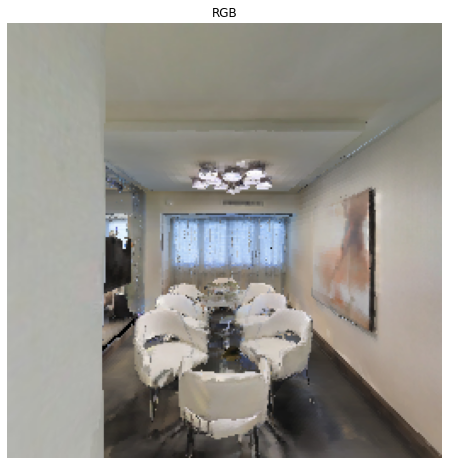

2) Action: move_forward


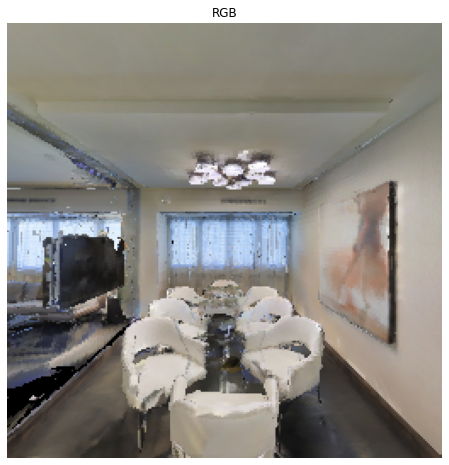

3) Action: turn_right


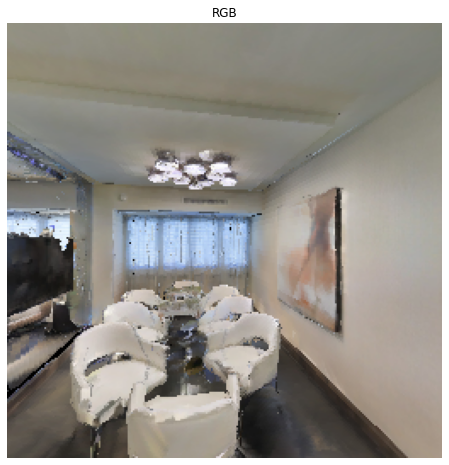

4) Action: move_forward


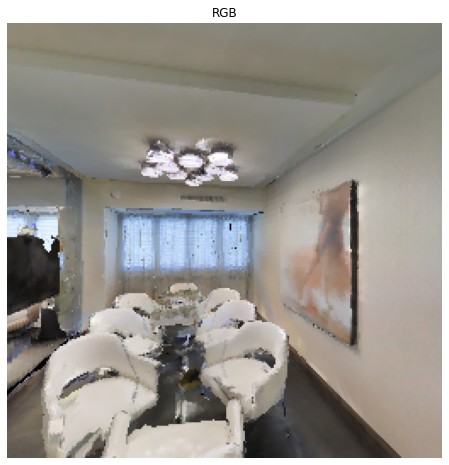

5) Action: turn_left


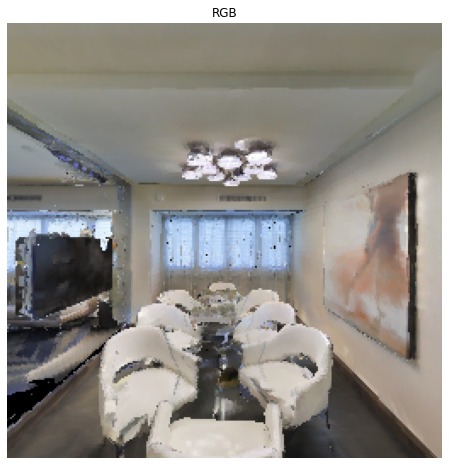

In [12]:
# Action sequence
actions = ["move_forward", "move_forward", "turn_right", 
    "move_forward", "turn_left"]
for i, action in enumerate(actions):
    print(f"{i+1}) ", end="")
    obs = navigateAndSee(action)

In [18]:
if obs["collided"]:
    print("The agent has collided with an obstacle in the environment")
else:
    print("The agent has not collided to anything in the environment")

The agent has not collided to anything in the environment


In [27]:
img = Image.fromarray(obs["color_sensor"])
img.save(f"{out_dir}/first_rgb.png")
print(f"Saving current view as PNG")

Saving current view as PNG


## Beyond Getting Started

We'll do the following over the above
- An agent with RGB, Depth, and Semantic sensors in a scene
- Exploring all entities in a semantic scene (to see what it contains)


In [ ]:
# TODO: Upcoming work